In [1]:
from matplotlib import pylab as plt

import lsst.daf.persistence as dp
import lsst.afw.display as display
import lsst.afw.display.rgb as rgb
import lsst.geom as geom

import numpy as np
import os, glob

import mysql
from mysql.connector import Error

import pandas as pd
import cv2
from tifffile import imread, imwrite

In [2]:
repo = "/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1"
butler = dp.Butler(repo)

/tmp/ipykernel_548/983700186.py:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dp.Butler(repo)
/tmp/ipykernel_548/983700186.py:2: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dp.Butler(repo)


lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading 

In [3]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} merged tracts in repo {}".format(num_tracts, repo))

Found 173 merged tracts in repo /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1


In [289]:
tracts[::10]

[2723,
 2733,
 2903,
 3077,
 3256,
 3266,
 3448,
 3634,
 3825,
 3835,
 4029,
 4227,
 4428,
 4438,
 4642,
 4851,
 5062,
 5072]

In [4]:
tract = 3448
skyMap = butler.get("deepCoadd_skyMap")
tractInfo = skyMap[tract]
print(tractInfo)

TractInfo(id=3448)


In [5]:
patchs = sorted([os.path.basename(x) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', str(tract), '*'))])

In [54]:
patchs

['0,0',
 '0,1',
 '0,2',
 '0,3',
 '0,4',
 '0,5',
 '0,6',
 '1,0',
 '1,1',
 '1,2',
 '1,3',
 '1,4',
 '1,5',
 '1,6',
 '2,0',
 '2,1',
 '2,2',
 '2,3',
 '2,4',
 '2,5',
 '2,6',
 '3,0',
 '3,1',
 '3,2',
 '3,3',
 '3,4',
 '3,5',
 '3,6',
 '4,0',
 '4,1',
 '4,2',
 '4,3',
 '4,4',
 '4,5',
 '4,6',
 '5,0',
 '5,1',
 '5,2',
 '5,3',
 '5,4',
 '5,5',
 '5,6',
 '6,0',
 '6,1',
 '6,2',
 '6,3',
 '6,4',
 '6,5',
 '6,6']

In [33]:
patch = (2,5)
patchInfo = tractInfo.getPatchInfo(patch)

In [34]:
poly = patchInfo.getInnerSkyPolygon(tractInfo.getWcs())
wcs = tractInfo.getWcs()
vertices = poly.getVertices()
boxRa = []
boxDec = []
for pt in poly.getVertices():
    boxRa.append(geom.SpherePoint(pt).getRa().asDegrees())
    boxDec.append(geom.SpherePoint(pt).getDec().asDegrees())

In [35]:
print(np.min(boxRa), np.max(boxRa))
print(np.min(boxDec), np.max(boxDec))

62.99980343562638 63.286547045284955
-39.08804278286078 -38.8651404711971


In [36]:
ra_min = np.min(boxRa)
ra_max = np.max(boxRa)
dec_min = np.min(boxDec)
dec_max = np.max(boxDec)

In [37]:
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040) 
cursor = conn.cursor(dictionary=True, buffered=True) 

In [11]:
query = "SHOW DATABASES;"
cursor.execute(query)
res = cursor.fetchall()
res

[{'Database': 'cosmoDC2_v1_1_4_image'},
 {'Database': 'dc2_object_run22i_dr6_wfd_v2_00'},
 {'Database': 'dp01_dc2_catalogs'},
 {'Database': 'information_schema'},
 {'Database': 'qservCssData'},
 {'Database': 'qservMeta'},
 {'Database': 'qservResult'},
 {'Database': 'test'}]

In [22]:
query = "SHOW TABLES IN cosmoDC2_v1_1_4_image;"
cursor.execute(query)
cursor.fetchall()

[{'Tables_in_cosmoDC2_v1_1_4_image': 'data'},
 {'Tables_in_cosmoDC2_v1_1_4_image': 'position'}]

In [38]:
mmin = 1.e14 #Msun
zmax = 1.3
#z0max = 1.5 #Rest-frame absolute magnitude, not lensed, in 'z'


query = "SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id "
query += "FROM cosmoDC2_v1_1_4_image.data as data "
query += f"WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, {ra_min}, {dec_min}, {ra_max}, {dec_max}) = 1 "
query += f"AND data.halo_mass>{mmin} AND data.redshift<{zmax} "
#query += "AND data.is_central = 1 " 
#query += f"AND data.Mag_true_z_lsst_z0 < {z0max} "
query += ";"
query

'SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id FROM cosmoDC2_v1_1_4_image.data as data WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, 62.99980343562638, -39.08804278286078, 63.286547045284955, -38.8651404711971) = 1 AND data.halo_mass>100000000000000.0 AND data.redshift<1.3 ;'

In [39]:
%%time
tab = pd.read_sql_query(query,conn)
len(tab)

CPU times: user 20.1 ms, sys: 2.8 ms, total: 22.9 ms
Wall time: 2.75 s


155

In [40]:
z = tab.groupby(['halo_id'])
z.size()

halo_id
2224600142266      8
2476100142247    147
dtype: int64

In [41]:
skyBbox = []
for halo, df in z:
    if len(df) < 5 :
        continue
    min = geom.SpherePoint(df.coord_ra.min()*geom.degrees, df.coord_dec.min()*geom.degrees)
    max = geom.SpherePoint(df.coord_ra.max()*geom.degrees, df.coord_dec.max()*geom.degrees)
    print(halo, df.halo_id.to_list()[0], min, max, df.redshift.to_list()[0], df.halo_mass.to_list()[0]*1.e-14)
    skyBbox.append([halo, min, max])

2224600142266 2224600142266 (63.2452193101, -39.0721176019) (63.2857022815, -39.0191321145) 0.8559183651829327 4.704500556352902
2476100142247 2476100142247 (63.0697802710, -39.0869560550) (63.1670538162, -39.0321463333) 1.0109084679663778 1.8780876373092958


In [42]:
skyBbox

[[2224600142266,
  SpherePoint(63.24521931006276*geom.degrees, -39.07211760185775*geom.degrees),
  SpherePoint(63.28570228153071*geom.degrees, -39.01913211451622*geom.degrees)],
 [2476100142247,
  SpherePoint(63.0697802710017*geom.degrees, -39.08695605498013*geom.degrees),
  SpherePoint(63.16705381616608*geom.degrees, -39.032146333326764*geom.degrees)]]

In [43]:
innerBbox = patchInfo.getInnerBBox()
outerBbox = patchInfo.getOuterBBox()
dX = 0.5*(outerBbox.getWidth()-innerBbox.getWidth())
dY = 0.5*(outerBbox.getHeight()-innerBbox.getHeight())
print(dX, dY)

100.0 100.0


In [44]:
print(innerBbox)
print(outerBbox)

(minimum=(8000, 20000), maximum=(11999, 23999))
(minimum=(7900, 19900), maximum=(12099, 24099))


In [47]:
innerBbox = patchInfo.getInnerBBox()
outerBbox = patchInfo.getOuterBBox()
dX = innerBbox.beginX-outerBbox.beginX
dY = innerBbox.beginY-outerBbox.beginY
print(dX, dY)

100 100


In [48]:
patchName = str(patch[0]) + ',' + str(patch[1])
print(tract, patchName)
dataId = {'tract':tract, 'patch':patchName}

bandpass_color_map = {'green':'r', 'red':'i', 'blue':'g'}

exposures = {}
for bandpass in bandpass_color_map.values():
    dataId['filter'] = bandpass
    exposures[bandpass] = butler.get('deepCoadd', dataId=dataId)

rgb_im = rgb.makeRGB(*(exposures[bandpass_color_map[color]].getMaskedImage()[innerBbox].getImage()
                       for color in ('red', 'green', 'blue')), Q=8, minimum = -0.1, dataRange=1.5, 
                       saturatedPixelValue=100,
                       xSize=None, ySize=None)

3448 2,5


In [57]:
##### Warning ######
# Need to subtract X0, Y0 to coordinate returned by skyToPixel in order to be in CCD natural coordinates
#coadd_r.getXY0()
#XY0 = exposures['r'].getXY0()
X0 = exposures['r'].getX0()
Y0 = exposures['r'].getY0()
print(X0, Y0)

7900 19900


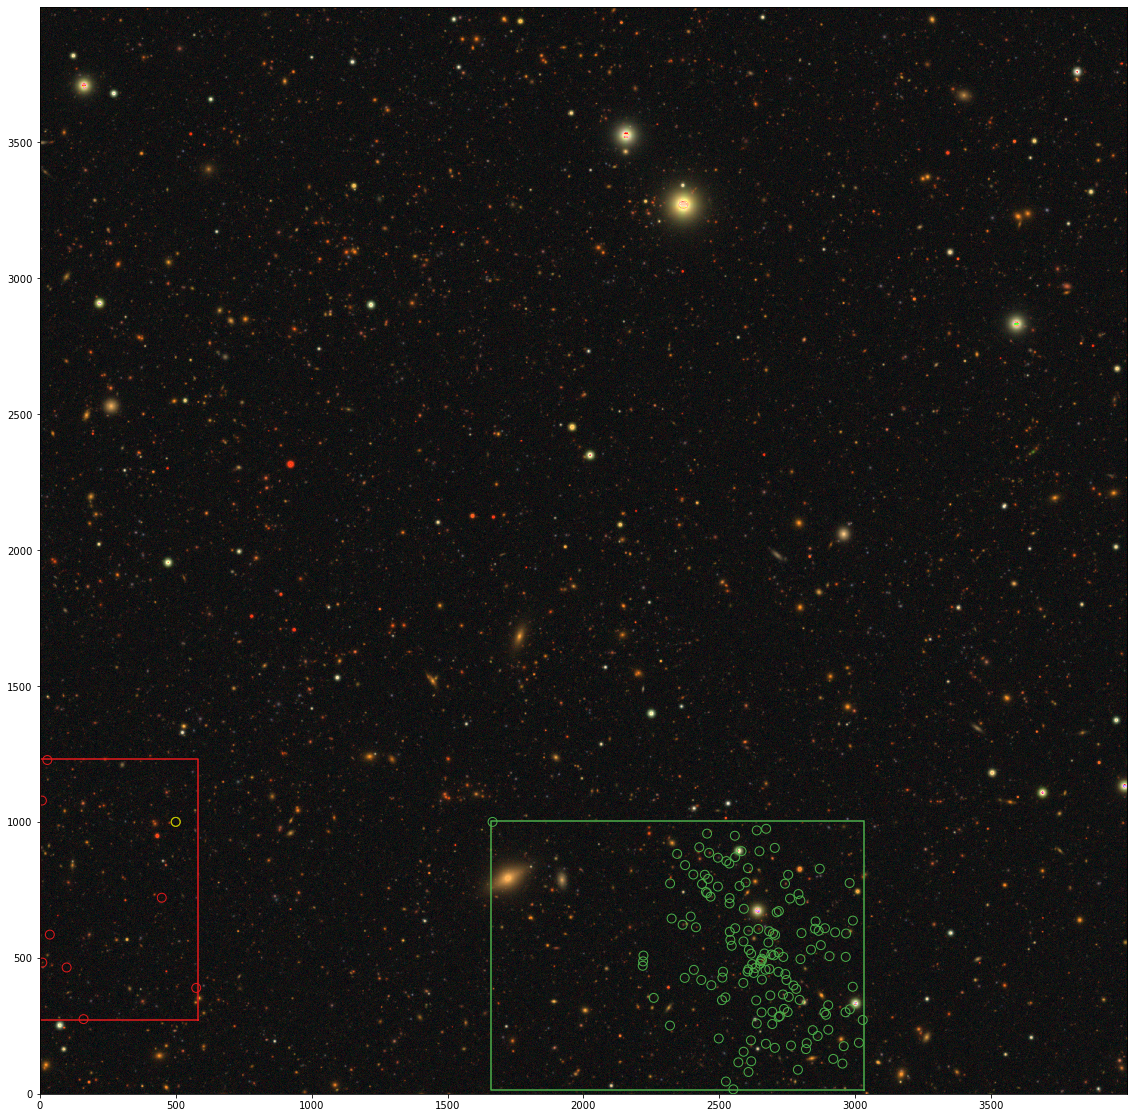

In [58]:
import matplotlib.cm as cm

colors = cm.Set1(np.linspace(0, 1, 5))

e = 5
display.setDefaultBackend("matplotlib")

fig = plt.figure(figsize=(20, 20))
disp = rgb.displayRGB(rgb_im, show=False)
#disp.line([(8500, 24000), (8500, 25000)], ctype='yellow')

for sky, c in zip(skyBbox, colors):
    box = wcs.skyToPixel(sky[1:])
    X = [box[0].getX()-X0+e-dX, box[0].getX()-X0+e-dX, box[1].getX()-X0-e-dX, box[1].getX()-X0-e-dX, box[0].getX()-X0+e-dX]
    Y = [box[0].getY()-Y0-e-dY, box[1].getY()-Y0+e-dY, box[1].getY()-Y0+e-dY, box[0].getY()-Y0-e-dY, box[0].getY()-Y0-e-dY]
    disp.plot(X,Y, color=c)

count = 0
for halo, df in z:
    if len(df) < 5 :
        continue
    c = colors[count]
    count += 1
    galX = []
    galY = []
    for k in range(len(df)):
        p = geom.SpherePoint(list(df.coord_ra)[k]*geom.degrees, list(df.coord_dec)[k]*geom.degrees)
        galX.append(wcs.skyToPixel(p).getX()-X0-dX)
        galY.append(wcs.skyToPixel(p).getY()-Y0-dY)
    disp.scatter(galX, galY, s=80, facecolors='none', edgecolors=c)
    disp.scatter([500], [1000], s=80, facecolors='none', edgecolors="y")

In [59]:
for sky, c in zip(skyBbox, colors):
    box = wcs.skyToPixel(sky[1:])
    x0 = box[0].getX()-X0+e-dX
    y0 = 3999 - (box[0].getY()-Y0-e)-dY
    x1 = box[1].getX()-X0-e-dX
    y1 = 3999 - (box[1].getY()-Y0+e)-dY
    dx = x0 - x1
    dy = y0 - y1
    #print(x0, y0, x1, y1, dx, dy)
    print(x1, y1, dx, dy) # ==> I should take these as bounding box parameters for YOLO
    #print(box[0].getX()-X0, box[0].getY()-Y0, box[1].getX()-X0, box[1].getY()-Y0)
    print()

0.47079098490121396 2566.5946689041084 580.2759288160169 961.2439432046158

1660.6244753828323 2794.1299130937186 1372.4729492484203 992.7096953224609



In [52]:
print(box[0].getX()-X0, box[0].getY()-Y0, box[1].getX()-X0, box[1].getY()-Y0)

3128.0974246312526 117.16039158382046 1765.6244753828323 1099.8700869062814


In [56]:
X0

7900

In [186]:
skyBbox

[[2239400068259,
  SpherePoint(61.95926486131193*geom.degrees, -30.422298655028015*geom.degrees),
  SpherePoint(62.04036083860465*geom.degrees, -30.38366525252442*geom.degrees)],
 [2346300068224,
  SpherePoint(62.00868698189096*geom.degrees, -30.580589272624067*geom.degrees),
  SpherePoint(62.06715624230007*geom.degrees, -30.479534297572773*geom.degrees)]]

In [31]:
name = str(tract) + '_' + patchName + '.png'
fig.savefig(name)

In [308]:
print("tract: {} - patch: {}".format(tract, patchName))
for halo, df in z:
    if len(df) < 5 :
        continue
    print("halo_id: {:d}, z={:.2f}, mass={:.2e}".format(halo, df.redshift.to_list()[0], df.halo_mass.to_list()[0]))

tract: 3448 - patch: 1,5
halo_id: 465800142323, z=0.52, mass=1.21e+14
halo_id: 2224600142266, z=0.86, mass=4.70e+14


In [312]:
exposures = {}
for bandpass in ['u', 'g', 'r', 'i', 'z', 'y']:
    dataId['filter'] = bandpass
    exposures[bandpass] = butler.get('deepCoadd', dataId=dataId)


In [313]:
im_i = exposures['i'].getMaskedImage()[innerBbox].getImage().getArray()
im_r = exposures['r'].getMaskedImage()[innerBbox].getImage().getArray()
im_g = exposures['g'].getMaskedImage()[innerBbox].getImage().getArray()
im_u = exposures['u'].getMaskedImage()[innerBbox].getImage().getArray()
im_z = exposures['z'].getMaskedImage()[innerBbox].getImage().getArray()
im_y = exposures['y'].getMaskedImage()[innerBbox].getImage().getArray()

In [314]:
print(np.min(im_u), np.min(im_g), np.min(im_r), np.min(im_i), np.min(im_z), np.min(im_y))
print(np.max(im_u), np.max(im_g), np.max(im_r), np.max(im_i), np.max(im_z), np.max(im_y))

-0.38752133 -0.15309769 -0.16751006 -0.29181194 -0.8548667 -1.5693232
4952.1025 1046.7175 1178.3783 1549.2991 2194.989 4602.4917


In [315]:
fullImage = np.dstack((im_u+60, im_g+60, im_r+60, im_i+60, im_z+60, im_y+60))

In [317]:
fullImage.shape

(4000, 4000, 6)

In [170]:
imwrite('multi-channel.tif', fullImage)

In [177]:
fullImage.shape

(4200, 4200, 6)

In [285]:
im_i.shape[1]

4200

In [174]:
im = cv2.imread('multi-channel.tif', -1)

In [175]:
im

array([[60.01615 , 60.001225, 59.93507 , 60.067127, 59.917385, 59.957962],
       [59.934826, 59.999424, 59.967396, 60.01757 , 59.79685 , 60.089222],
       [59.943233, 60.022835, 60.004925, 60.064495, 59.707832, 60.43509 ],
       ...,
       [60.216213, 60.25689 , 60.531574, 60.74912 , 61.012   , 61.749733],
       [60.128796, 60.29658 , 60.571907, 60.86653 , 61.086414, 61.152508],
       [59.938587, 60.265587, 60.524406, 60.796124, 61.0348  , 61.33753 ]],
      dtype=float32)

In [176]:
im.shape

(4200, 6)

In [179]:
im2 = imread('multi-channel.tif')

In [181]:
im2.shape

(4200, 4200, 6)

In [319]:
outerBbox = patchInfo.getOuterBBox()

In [324]:
print(innerBbox.getWidth(), innerBbox.getHeight(), outerBbox.getWidth(), outerBbox.getHeight())

4000 4000 4200 4200


In [321]:
innerBbox

Box2I(minimum=Point2I(4000, 20000), dimensions=Extent2I(4000, 4000))